In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

In [3]:
import numpy as np
import torch
import torch.optim as optim
import pandas as pd
from abn.models.spherical_vae import SphericalVAE
from abn.trainer.svae_trainer import SphericalVAETrainer
from abn.datasets.cyclic_walk import CyclicWalk
from abn.datasets.wiggles import Wiggles
from abn.datasets.data_loader import TrainValLoader

# Hyperspherical VAE

## Load Dataset

40it [00:41,  1.03s/it]
/Users/sophia/projects/abn/abn/notebooks/../../abn/datasets/cyclic_walk.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(angles, dtype=torch.float32)


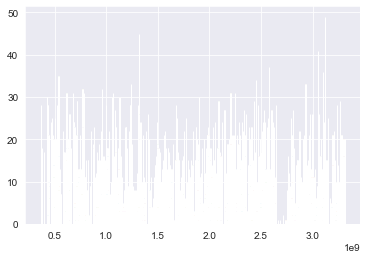

In [19]:
path = "../data/expt34.mat" # CHANGE TO YOUR DATA LOCATION IF NEEDED
time_bin = 1000000
dataset = CyclicWalk(path=path, time_bin=time_bin, velocity_threshold=0.3)

In [10]:
# torch.save(dataset, "../data/expt34_processed.pt")

In [23]:
dataset = torch.load("../data/expt34_processed.pt")

## Normalize the Data

Note: Different normalization schemes have a *HUGE* impact on the training procedure.
Options that should be explored include:
- Z-scoring each neuron's response across the entire dataset
- Setting min of the entire dataset to 0 and max to 1
- Setting the norm of each neural state vector to 1

They are each implemented below. Uncomment options to try them out

In [66]:
"""
Z-Scoring
"""
# dataset.data = dataset.data - dataset.data.mean(axis=-1, keepdim=True)
# dataset.data = dataset.data / dataset.data.std(axis=-1, keepdim=True)
# print(dataset.data.std(axis=-1))

'\nZ-Scoring\n'

In [20]:
"""
Min 0 Max 1
"""
dataset.data = dataset.data - dataset.data.min()
dataset.data = dataset.data / dataset.data.max()

In [21]:
"""
Unit Norm
"""
# dataset.data = dataset.data / torch.linalg.norm(dataset.data, dim=-1, keepdim=True)
# print(torch.linalg.norm(dataset.data, dim=-1))

'\nUnit Norm\n'

## Train Val Split and Generate Batches

In [22]:
data_loader = TrainValLoader(batch_size=20)
data_loader.load(dataset)

## Construct Model

In [23]:
model = SphericalVAE(input_dim=40,
                     encoder_dims=[40, 30, 20, 10],
                     latent_dim=2,
                     distribution="vmf")

optimizer = optim.Adam(model.parameters(), lr=0.001)

trainer = SphericalVAETrainer(model=model, optimizer=optimizer)

In [24]:
model

SphericalVAE(
  (encoder): Sequential(
    (fullyconnected_0): Linear(in_features=40, out_features=40, bias=True)
    (activation_0): ReLU()
    (fullyconnected_1): Linear(in_features=40, out_features=30, bias=True)
    (activation_1): ReLU()
    (fullyconnected_2): Linear(in_features=30, out_features=20, bias=True)
    (activation_2): ReLU()
    (fullyconnected_3): Linear(in_features=20, out_features=10, bias=True)
    (out_3): ReLU()
  )
  (mu): Linear(in_features=10, out_features=2, bias=True)
  (var): Linear(in_features=10, out_features=1, bias=True)
  (decoder): Sequential(
    (fullyconnected_0): Linear(in_features=2, out_features=10, bias=True)
    (activation_0): ReLU()
    (fullyconnected_1): Linear(in_features=10, out_features=20, bias=True)
    (activation_1): ReLU()
    (fullyconnected_2): Linear(in_features=20, out_features=30, bias=True)
    (activation_2): ReLU()
    (fullyconnected_3): Linear(in_features=30, out_features=40, bias=True)
    (activation_3): ReLU()
    (fu

## Train Model

In [ ]:
trainer.train(data_loader, 1000)

/Users/sophia/opt/anaconda3/envs/geomstats/lib/python3.8/site-packages/torch/distributions/distribution.py:45: UserWarning: <class 'abn.hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Epoch 0 ||  N Examples 347990 || Train Total Loss 9.06008 || Validation Total Loss 9.12940
Epoch 1 ||  N Examples 348880 || Train Total Loss 9.05746 || Validation Total Loss 9.09489
Epoch 2 ||  N Examples 349770 || Train Total Loss 9.06534 || Validation Total Loss 9.10109
Epoch 3 ||  N Examples 350660 || Train Total Loss 9.05427 || Validation Total Loss 9.09516


## Visualize Latent Space

In [32]:
with torch.no_grad():
    (z_mean, z_var), (q_z, p_z), z = model.to_latent(dataset.data)

In [33]:
df = pd.DataFrame({"z0": z[:, 0], 
                    "z1": z[:, 1], 
                    "pos": dataset.labels % (2 * np.pi)})
#                     "pos": (dataset.pos + dataset.angle) % (2 * np.pi)})

<AxesSubplot:xlabel='z0', ylabel='z1'>

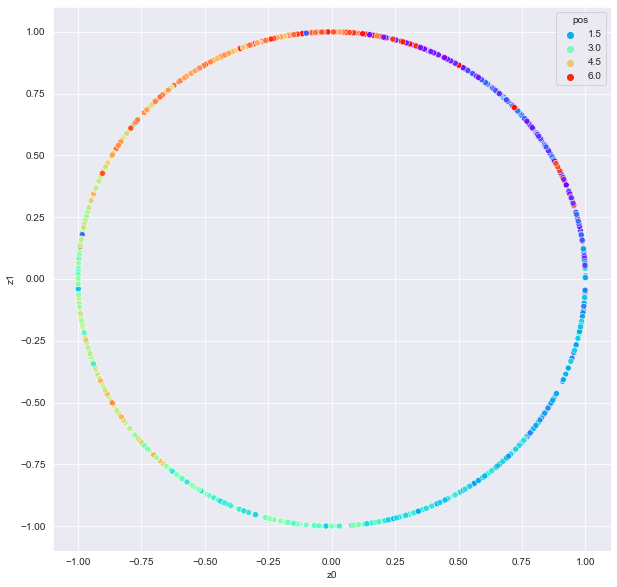

In [34]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="z0", y="z1", hue="pos", data=df, palette="rainbow")